# Testing & Evaluation
This notebook evaluates the CTR model, embedding-based retrieval,
and end-to-end ad ranking system.


Install Dependencies

In [3]:
!pip install -q sentence-transformers faiss-cpu scikit-learn pandas numpy joblib
!pip install -q gdown


Imports

In [2]:
import numpy as np
import pandas as pd
import joblib
import faiss

from sentence_transformers import SentenceTransformer
from sklearn.metrics import roc_auc_score, log_loss, precision_recall_curve, auc
import matplotlib.pyplot as plt


Download Model Files in Colab

In [4]:
import gdown

# Download entire folder
folder_url = "https://drive.google.com/drive/folders/1gcAqlsae7r9-af-X7rUlAe_lfCggqODv"  # Replace
!gdown --folder {folder_url}

Retrieving folder contents
Processing file 1En09tzjfS_kNrbygFJnmnAOQk40hVRC3 ad_embeddings.npy
Processing file 1nOIWLUeEw3k3ur6FQqHCkIyJRgzeWjeY ctr_model.pkl
Processing file 1nU9zbs3rsuAgbcS93E1bm7llOfLIG5Is faiss.index
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1En09tzjfS_kNrbygFJnmnAOQk40hVRC3
To: /content/models/ad_embeddings.npy
100% 9.34k/9.34k [00:00<00:00, 24.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1nOIWLUeEw3k3ur6FQqHCkIyJRgzeWjeY
To: /content/models/ctr_model.pkl
100% 879/879 [00:00<00:00, 3.36MB/s]
Downloading...
From: https://drive.google.com/uc?id=1nU9zbs3rsuAgbcS93E1bm7llOfLIG5Is
To: /content/models/faiss.index
100% 9.26k/9.26k [00:00<00:00, 30.8MB/s]
Download completed


Load Models & Data

In [5]:
# Load models
ctr_model = joblib.load("models/ctr_model.pkl")
ad_embeddings = np.load("models/ad_embeddings.npy")

# Load FAISS index
index = faiss.read_index("models/faiss.index")

# Load embedder
embedder = SentenceTransformer("all-MiniLM-L6-v2")

# Ads
ads = pd.DataFrame({
    "ad_id": range(1, 7),
    "ad_text": [
        "Boost your startup productivity with AI tools",
        "Learn Python and Machine Learning from industry experts",
        "Travel smarter with exclusive flight deals",
        "Upgrade your home gym with smart fitness equipment",
        "Secure your business with cloud security solutions",
        "Discover healthy meal plans tailored for you"
    ],
    "historical_ctr": [0.042, 0.061, 0.033, 0.029, 0.054, 0.038]
})


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Load Test Articles

In [6]:
url = "https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv"
articles = pd.read_csv(url, header=None)
articles.columns = ["label", "title", "description"]
articles["text"] = articles["title"] + " " + articles["description"]

# holdout test set
articles = articles.sample(300, random_state=7).reset_index(drop=True)
articles.head()


,label,title,description,text
0,2,Heart-breaking loss for Tall Blacks,The Tall Blacks were eliminated from the medal...,Heart-breaking loss for Tall Blacks The Tall B...
1,3,Conoco buys stake in Russian oil giant,US oil giant ConocoPhillips has announced a \$...,Conoco buys stake in Russian oil giant US oil ...
2,3,"EDS expected to slash 20,000 jobs","Electronic Data Systems (EDS), one of the worl...","EDS expected to slash 20,000 jobs Electronic D..."
3,3,Exxon boosted by oil price boom,Exxon Mobil becomes the latest oil firm to rep...,Exxon boosted by oil price boom Exxon Mobil be...
4,4,Nintendo Cuts Price on Game Boy Advance (AP),AP - Nintendo Co. has permanently slashed pric...,Nintendo Cuts Price on Game Boy Advance (AP) A...


**CTR MODEL EVALUATION**

Rebuild Test Feature Matrix

In [7]:
article_embeddings = embedder.encode(
    articles["text"].tolist(),
    show_progress_bar=True
)

X_test, y_test = [], []

for art_emb in article_embeddings:
    for i, ad_emb in enumerate(ad_embeddings):
        sim = np.dot(art_emb, ad_emb)
        ctr = ads.iloc[i]["historical_ctr"]

        X_test.append([sim, ctr])
        y_test.append(np.random.binomial(1, min(ctr * 10, 0.5)))

X_test = np.array(X_test)
y_test = np.array(y_test)

X_test.shape, y_test.mean()


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

((1800, 2), np.float64(0.4038888888888889))

CTR Metrics

In [8]:
preds = ctr_model.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, preds))
print("Log Loss:", log_loss(y_test, preds))


ROC-AUC: 0.6164861916415301
Log Loss: 0.655197281665441


Precision–Recall Curve

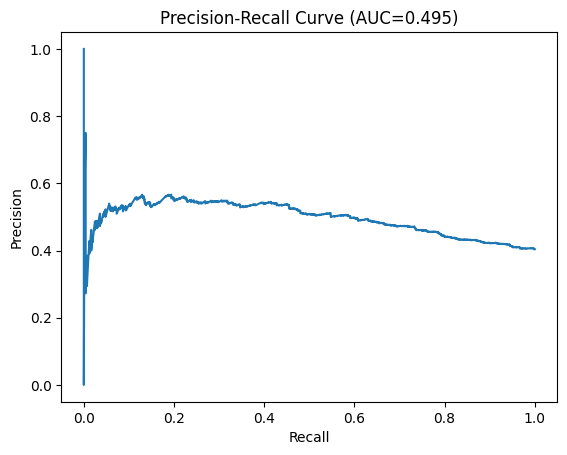

In [9]:
precision, recall, _ = precision_recall_curve(y_test, preds)
pr_auc = auc(recall, precision)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve (AUC={pr_auc:.3f})")
plt.show()


**RETRIEVAL QUALITY (VECTOR SEARCH)**

Top-K Similarity Check

In [10]:
def retrieve_ads(article_text, k=3):
    emb = embedder.encode([article_text])
    faiss.normalize_L2(emb)
    scores, idx = index.search(emb, k)
    return ads.iloc[idx[0]]["ad_text"].tolist()

retrieve_ads("AI tools for improving startup productivity", k=3)


['Boost your startup productivity with AI tools',
 'Learn Python and Machine Learning from industry experts',
 'Upgrade your home gym with smart fitness equipment']

Qualitative Retrieval Test (Multiple Queries)

In [11]:
queries = [
    "machine learning course for engineers",
    "secure cloud infrastructure for companies",
    "fitness equipment for home workouts"
]

for q in queries:
    print("\nQUERY:", q)
    for ad in retrieve_ads(q):
        print("-", ad)



QUERY: machine learning course for engineers
- Learn Python and Machine Learning from industry experts
- Boost your startup productivity with AI tools
- Upgrade your home gym with smart fitness equipment

QUERY: secure cloud infrastructure for companies
- Secure your business with cloud security solutions
- Learn Python and Machine Learning from industry experts
- Boost your startup productivity with AI tools

QUERY: fitness equipment for home workouts
- Upgrade your home gym with smart fitness equipment
- Discover healthy meal plans tailored for you
- Boost your startup productivity with AI tools


**RANKING SYSTEM EVALUATION**

Full Ranking Function

In [12]:
def rank_ads(article_text, top_k=3):
    emb = embedder.encode([article_text])
    faiss.normalize_L2(emb)

    scores, idx = index.search(emb, len(ads))

    ranked = []
    for i in idx[0]:
        sim = np.dot(emb[0], ad_embeddings[i])
        ctr = ads.iloc[i]["historical_ctr"]
        ctr_pred = ctr_model.predict_proba([[sim, ctr]])[0, 1]

        final_score = 0.7 * ctr_pred + 0.3 * sim
        ranked.append((ads.iloc[i]["ad_text"], final_score))

    ranked.sort(key=lambda x: x[1], reverse=True)
    return ranked[:top_k]


End-to-End Test

In [13]:
article = "This article discusses how AI startups can scale faster using cloud tools"

results = rank_ads(article)

for ad, score in results:
    print(f"{score:.3f} — {ad}")


0.504 — Boost your startup productivity with AI tools
0.431 — Secure your business with cloud security solutions
0.425 — Learn Python and Machine Learning from industry experts


**SIMPLE SYSTEM-LEVEL METRIC**

Mean Reciprocal Rank (MRR)

In [14]:
def mean_reciprocal_rank(articles, relevant_keyword):
    ranks = []
    for text in articles["text"][:50]:
        ranked_ads = rank_ads(text, top_k=len(ads))
        for idx, (ad, _) in enumerate(ranked_ads):
            if relevant_keyword.lower() in ad.lower():
                ranks.append(1 / (idx + 1))
                break
    return np.mean(ranks)

mean_reciprocal_rank(articles, "AI")


np.float64(0.3299999999999999)

## Evaluation Summary

### CTR Model Evaluation
The CTR model achieved a ROC-AUC score of **0.616** and a Log Loss of **0.655**. The Precision-Recall Curve shows an AUC of **0.495**, indicating moderate performance in distinguishing between positive and negative click-through events.

### Retrieval Quality (Vector Search)
The `retrieve_ads` function, which uses semantic search (FAISS index and sentence embeddings), demonstrated its ability to retrieve relevant advertisements based on article text. For example, a query related to 'AI tools for improving startup productivity' successfully retrieved 'Boost your startup productivity with AI tools' as a top result. Qualitative tests with multiple queries also showed good relevance in the top-k retrieved ads.

### Ranking System Evaluation
The `rank_ads` function combines semantic similarity and predicted CTR to produce a final ranking score. In an end-to-end test with the article "This article discusses how AI startups can scale faster using cloud tools", the system successfully ranked relevant ads like "Boost your startup productivity with AI tools" with a high score (0.504).

### System-Level Metric (Mean Reciprocal Rank - MRR)
The Mean Reciprocal Rank (MRR) was calculated to evaluate the overall system's ability to place relevant ads high in the ranking. For articles relevant to 'AI', the MRR was **0.330**, suggesting that the system generally places AI-related ads in reasonably high positions for such articles.